In [ ]:
# Install libraries
# https://docs.tweepy.org/en/stable/index.html
# https://pypi.org/project/deep-translator/
# https://github.com/bsolomon1124/demoji
# https://pypi.org/project/textblob/
# https://pypi.org/project/flair/

%pip install tweepy
%pip install tweepy[async]
%pip install deep-translator
%pip install demoji
%pip install textblob 
%pip install flair

In [21]:
# Set-up notebook
import datetime
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import json
import tweepy
from tweepy import asynchronous
import time
from deep_translator import GoogleTranslator
import demoji
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')

format_time = '%Y-%m-%dT%H:%M:%SZ'
def cp_transform(check_point):
    check_point = str(check_point)[:-7].replace(' ','T') + 'Z'
    check_point = datetime.strptime(check_point,format_time)
    return check_point

check_point = cp_transform(datetime.now() - timedelta(days=6))
buffer = 0

flair_model = TextClassifier.load('en-sentiment')
def flair_prediction(x):
    sentence = Sentence(x)
    flair_model.predict(sentence)
    score = sentence.labels[0]
    if 'POSITIVE' in str(score):
        return 1
    elif 'NEGATIVE' in str(score):
        return -1
    else:
        return 0

2022-11-05 20:03:06,144 loading file C:\Users\ellie\.flair\models\sentiment-en-mix-distillbert_4.pt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ellie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Authenticate Twitter dev account
config_path = "tweets\config.json"

with open(config_path) as json_file:
    config = json.load(json_file)

bearer_token = config["bearer-token"]
client = tweepy.asynchronous.AsyncClient(bearer_token=bearer_token)

In [ ]:
# Set-up Twitter query
keyword = input('Please enter keyword or hashtag to search: ')
no_tweets = int(input ('Please enter how many tweets to analyze: '))

In [22]:
# Search recent tweets
start = datetime.now()
limit = int(np.ceil(no_tweets / 100))
data = []

while limit > 0:
    response = await client.search_recent_tweets(keyword, tweet_fields=['created_at', 'lang', 'geo','author_id'], 
                                start_time=check_point,max_results=100)
    data.extend(response.data)
    time.sleep(30)
    limit -= 1

df = pd.DataFrame.from_dict(data)

In [23]:
# Remove duplicate entries
df = df.drop_duplicates(['id'])
df = df.sort_values(by=['created_at'], ascending=False)
df = df.reset_index()

In [24]:
# Checkpoint time stamp
buffer = timedelta(seconds=1)
check_point = cp_transform(df['created_at'][0])


In [25]:
# Translate Twitter data
i = 0 # iterator
text_translated = []

for row in df.iterrows():
    translated = GoogleTranslator(source='auto', target='en').translate(df.loc[i]['text'])
    translated = demoji.replace_with_desc(translated)
    text_translated.append(translated)
    i += 1

df['text_translated'] = text_translated  

In [26]:
# Process Twitter data
i = 0 # iterator
textblob_sentiment = []
textblob_subjectivity = []
nltk_sentiment = []
flair_sentiment = []

for row in df.iterrows():
    
    textblob = TextBlob(df.loc[i]['text_translated'])
    nltk = SentimentIntensityAnalyzer().polarity_scores(df.loc[i]['text_translated'])
    flair = flair_prediction(df.loc[i]['text_translated'])
    
    textblob_sentiment.append(textblob.sentiment.polarity)
    textblob_subjectivity.append(textblob.subjectivity)
    nltk_sentiment.append(nltk['compound'])
    flair_sentiment.append(flair)
   
    i += 1

df['textblob_sentiment'] = textblob_sentiment
df['textblob_subjectivity'] = textblob_subjectivity
df['nltk_sentiment'] = nltk_sentiment
df['flair_sentiment'] = flair_sentiment

In [27]:
# Calculate composite score + class
i = 0 # iterator
score = []
score_class =[]

for row in df.iterrows():

    total_sentiment = df.loc[i]['textblob_sentiment'] + df.loc[i]['nltk_sentiment']
    
    if total_sentiment == 0:
        sentiment
    else:
        sentiment = abs(total_sentiment / 2)
    
    sub_sentiment = sentiment + df.loc[i]['textblob_subjectivity']
    polar_sentiment = sub_sentiment * df.loc[i]['flair_sentiment']
    
    if abs(polar_sentiment) > 1:
        prefix = 'strong '
    else: 
        prefix = ''
        
    if polar_sentiment > 0.15:
        polarity = 'positive'
    elif polar_sentiment < -0.15:
        polarity = 'negative'
    else:
        polarity = 'neutral'
        
    polarity = prefix + polarity
    
    score.append(polar_sentiment)
    score_class.append(polarity)
    i += 1
    
df['polar_sentiment'] = score
df['score_class'] = score_class

In [28]:
# Set buffer
end = datetime.now()
buffer = end - start + timedelta(seconds=3)
buffer

datetime.timedelta(seconds=178, microseconds=997927)

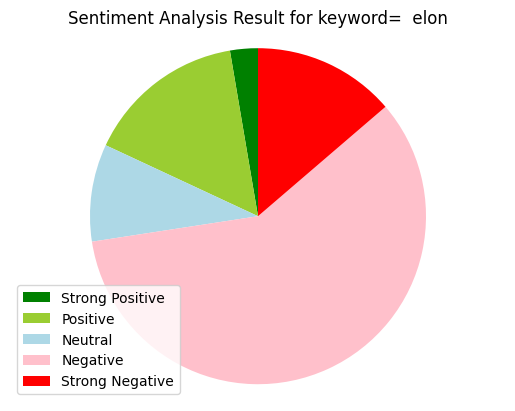

,index,author_id,created_at,edit_history_tweet_ids,geo,id,lang,text,text_translated,textblob_sentiment,textblob_subjectivity,nltk_sentiment,flair_sentiment,polar_sentiment,score_class
0,206,1585816319538171907,2022-11-06 03:04:48+00:00,[1589091400007954433],NaN,1589091400007954433,en,RT @iluminatibot: Bill Gates buying all sorts ...,RT @iluminatibot: Bill Gates buying all sorts ...,0.625000,0.500000,0.0000,-1,-0.812500,negative
1,199,280021509,2022-11-06 03:04:48+00:00,[1589091402591485952],NaN,1589091402591485952,es,RT @PFifiona: López Obrador dijo que iba a inv...,RT @PFifiona: López Obrador said he was going ...,-0.155556,0.288889,0.4019,-1,-0.412061,negative
2,200,292109098,2022-11-06 03:04:48+00:00,[1589091402423881730],NaN,1589091402423881730,en,RT @Black90Prupayne: And of course they can as...,RT @Black90Prupayne: And of course they can as...,0.250000,0.500000,-0.5719,-1,-0.660950,negative
3,201,931312901192855552,2022-11-06 03:04:48+00:00,[1589091401807327232],NaN,1589091401807327232,pt,RT @kimpaim: Watcher Guru: Elon Musk confirma ...,RT @kimpaim: Watcher Guru: Elon Musk confirms ...,0.000000,0.000000,0.0000,1,0.160950,positive
4,202,147941363,2022-11-06 03:04:48+00:00,[1589091401723441152],NaN,1589091401723441152,es,RT @AlertaNews24: 🇺🇸 | AHORA: Elon Musk anunci...,RT @AlertaNews24: :flag: United States: | NOW:...,0.000000,0.000000,0.6249,-1,-0.312450,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,95,901848797621493761,2022-11-06 03:03:37+00:00,[1589091104661856256],NaN,1589091104661856256,en,RT @ZackBornstein: You simply must admire the ...,RT @ZackBornstein: You simply must admire the ...,0.100000,0.228571,0.2617,1,0.409421,positive
295,96,1582626825347674112,2022-11-06 03:03:37+00:00,[1589091104636702723],NaN,1589091104636702723,en,@CPamp7 APESCOIN-MEMECOIN OF KING ELON MUSK\nR...,@CPamp7 APESCOIN-MEMECOIN OF KING ELON MUSK\nR...,0.200000,0.300000,0.0000,-1,-0.400000,negative
296,97,298292516,2022-11-06 03:03:37+00:00,[1589091103310872576],NaN,1589091103310872576,pt,RT @kimpaim: Watcher Guru: Elon Musk confirma ...,RT @kimpaim: Watcher Guru: Elon Musk confirms ...,0.000000,0.000000,0.0000,1,0.100000,neutral
297,98,1528757024007172101,2022-11-06 03:03:37+00:00,[1589091103277731840],NaN,1589091103277731840,en,RT @hpsromantic: Elon Musk should buy Quora an...,RT @hpsromantic: Elon Musk should buy Quora an...,0.000000,0.000000,0.0000,-1,-0.100000,neutral


In [29]:
#Create piechart
strong_positive = len(df[df['score_class'] == 'strong positive'])
positive = len(df[df['score_class'] == 'positive'])
neutral = len(df[df['score_class'] == 'neutral'])
negative = len(df[df['score_class'] == 'negative'])
strong_negative = len(df[df['score_class'] == 'strong negative'])

#labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
labels = ['Strong Positive', 'Positive','Neutral','Negative','Strong Negative']
sizes = [strong_positive, positive, neutral, negative, strong_negative]
colors = ['green','yellowgreen','lightblue','pink','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result for keyword=  '+keyword+'')
plt.axis('equal')
plt.show()

df